# INFINITY (is overrated) 

## IIR  Infinite Impulse Response Filters

### Stabilty, Causality, Recursion, Feedback, Oh My

## Discrete Time (Digital) IIR Filters are based on "Analog" Circuits, I.e. Transistors, Capacitors, Inductors.  Developed for Radio, Early Record Recording Playback.  Analog Console EQ, "Tone Controls". 

<img src="LTI.png">

# Now b AND a coefficients.  Filter can incorporate past values of Y (not just X).  Numerator and Denomonator. But if Denominator is zero, thats BAD... so IIR filters can be unstable (think audio feedback.  If this was a real in person conference, and I was using a reall microphone, you would hear feedback if I walked too close to a speaker.  This is same phenomena

<img src="lp.png">
Analog Lowpass (from Wikipedia)

# This Circuit can be mathematically modelled as a Differential Equation

# Then using the Laplace Transform, It can be transformed into a Rational Polynomial (S domain). 

# The Z transform is the discrete time version of the Laplace Transform. Both are closely related to the Fourier Transform. 

# Lots of Algebra... 

<img src="biquad.png">

<img src="df1.png">

<img src="cp10.png">

# Forget about Algebra!  Its the 21st Century! We have GPU's tuned for machine learning and Convolution Neural Networks

In [1]:
include("simplot.jl")
using PyPlot
using DSP 
using FFTW 
display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
function cp10hH(centerHz,octave3dB,gaindB,f_samp,P)
    
    f_nyq = f_samp / 2;
    T = 1 ./ f_samp;

    if gaindB >= 0
        boostcutflag = 1
    else
        boostcutflag = 0
    end
    
    gaindB = abs(gaindB) 

    ## % Pf is prewarped frequency (from Matlab "doc bilinear")
    f_p = centerHz;
    Pf = (2 .* pi .* f_p) / ( tan(pi .* (f_p / f_samp)));
    G = 10^(gaindB / 20);
    Q = 1.43 / octave3dB;

    W = 2 * pi * centerHz;

    bzmath = zeros(3,1)
    azmath = zeros(3,1) 

    if boostcutflag == 0
        ## CUT equation
        ## from Mathematica 
        bzmath[1] = Pf.^2 .* Q .+ Pf .* W .+ Q .* W.^2;
        bzmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        bzmath[3] = Pf.^2 .*Q .- Pf .* W .+ Q .* W.^2;

        azmath[1] = Pf.^2 .* Q .+ G .* Pf .* W + Q .* W.^2;
        azmath[2] =  -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        azmath[3] =  Pf.^2 .*Q - G .* Pf .* W .+ Q .* W.^2;

        bzmath = bzmath ./ azmath[1];
        azmath = azmath ./ azmath[1];
    end

    
    if boostcutflag == 1 
    
        ## BOOST equation 
        bzmath[1] = Pf.^2 .* Q .+ G .* Pf .* W .+ Q .* W.^2;
        bzmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        bzmath[3] = Pf.^2 .* Q .- G .* Pf .* W .+ Q .* W.^2;
  
        azmath[1] = Pf.^2 .* Q .+ Pf .* W .+ Q .* W.^2;
        azmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        azmath[3] = Pf.^2 .* Q .- Pf .* W .+ Q .* W.^2;

        bzmath = bzmath ./ azmath[1];
        azmath = azmath ./ azmath[1];

    end


    b0 = bzmath[1]
    b1 = bzmath[2]
    b2 = bzmath[3]

    a0 = azmath[1];
    a1 = azmath[2];
    a2 = azmath[3];

    b = bzmath;
    a = azmath;

    ## calculationg H(e^{j w}) (Fourier transform) 
    n = 0:(P-1);
    n2 = 0:(P/2);
    f2 = (f_samp .* n2) ./ P
    H2 = zeros(div(P,2) + 1,1)

    z = exp.(im .* 2 .* pi .* (n ./ P));
    Htop  = b0 .+ b1 .* z.^(-1) .+ b2 .* z.^(-2);
    Hbot = 1 .+ a1 .* z.^(-1) .+ a2 .* z.^(-2);
    H = Htop ./ Hbot;

    H2 = H[1:div(P,2)+1]

    B = b2/a2;
    c1 = b1 - ((b2/a2)*a1);
    c0 = b0 - (b2/a2);

    alpha = (-a1 + sqrt(complex(a1^2 - 4 * a2)))/2;
    beta = (-a1 - sqrt(complex(a1^2 - 4 * a2)))/2;

    A1 = ((c1 / alpha) + c0) / ( 1 - (beta / alpha));
    
    A2 = ( (c1 / beta) + c0) / ( 1 - (alpha / beta));

    h = zeros(P,1)


    h[n[1]+1] = B .+ A1 .+ A2;
    h[ n[2:end] .+ 1,1] = A1 .* alpha.^( n[2:end]) .+ A2 .* beta.^(n[2:end]);

    ## note equivalence of h versus hifft f
    ##maximum(  abs.(h - real(ifft(H)) ))

    return f2,H2,b,a,h,H
    
end



cp10hH (generic function with 1 method)

In [3]:
f2,H2,b,a,h,H= cp10hH(5000,0.5,-18,96e3,2^12);

In [4]:
f_samp = 48e3
dt = 1 / f_samp
N = 5000
n = collect(0:(N-1))
x1 = sin.(2 * pi * 20 * n ./ f_samp)
x2 = sin.(2 * pi * 5000 * n ./ f_samp)
x = x1 + x2;


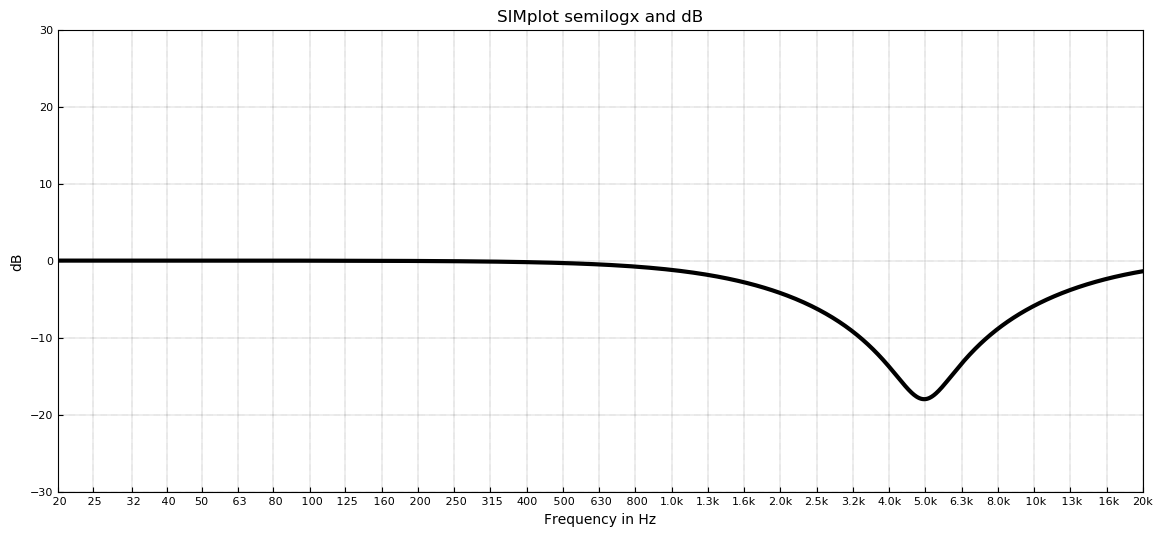

PyObject Text(0.5, 1, 'SIMplot semilogx and dB')

In [5]:
fig = figure("Title of Window",figsize=(14,6))
simplot(f2,H2)

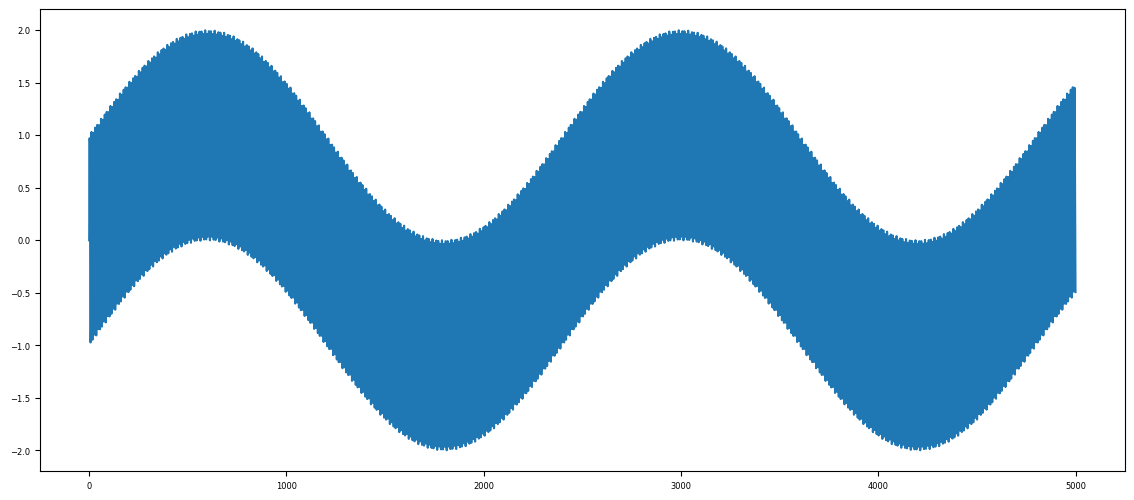

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473ccafd7c0>

In [6]:
fig = figure("Title of Window",figsize=(14,6))
plot(x)

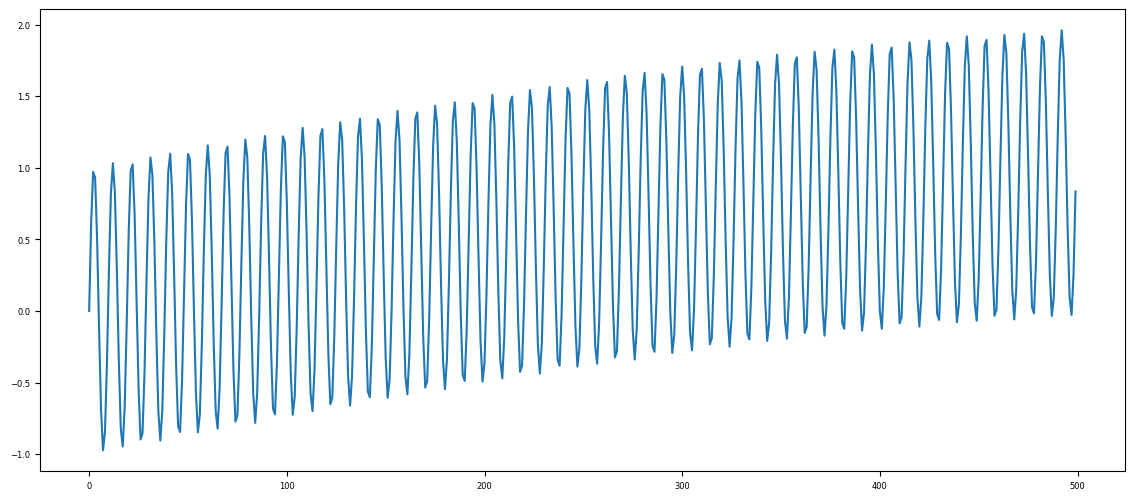

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473cce0e790>

In [7]:
fig = figure("Title of Window",figsize=(14,6))
plot(x[1:500])

In [8]:
y = filt(vec(b),vec(a),x);

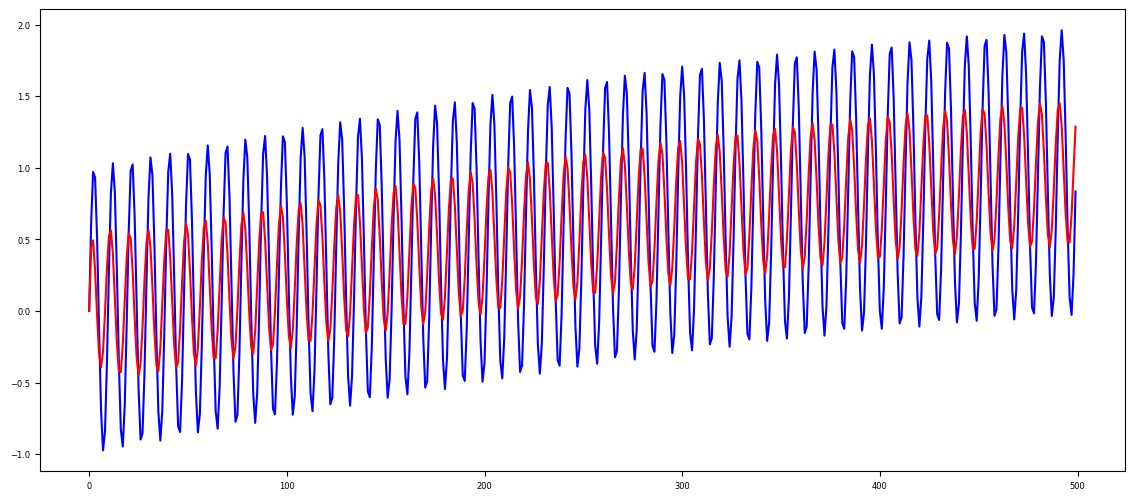

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473ccde1f10>

In [9]:
fig = figure("Title of Window",figsize=(14,6))
plot(x[1:500],"-b")
plot(y[1:500],"-r")

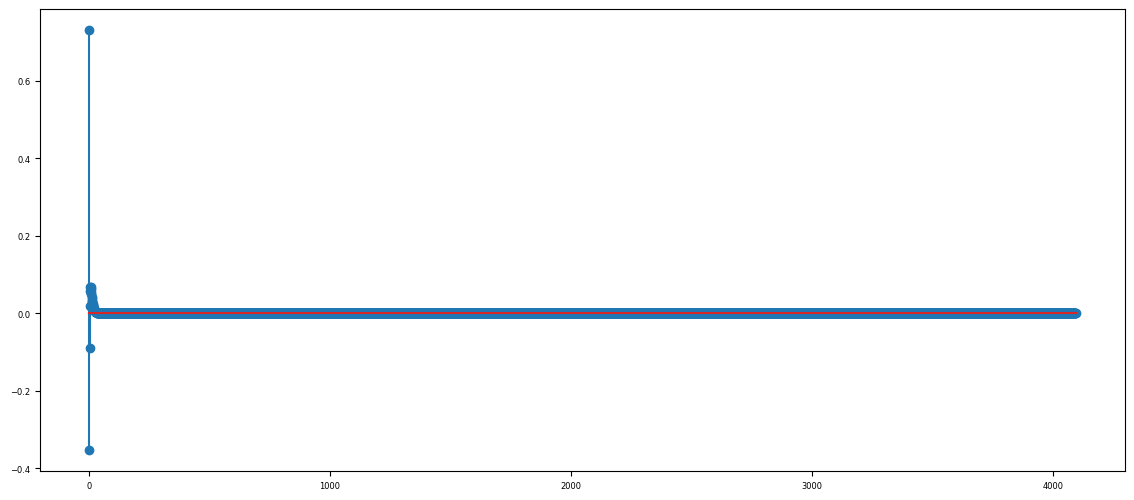

(PyObject <matplotlib.lines.Line2D object at 0x1473ccd3e640>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x1473ccd3e670>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd3e6a0>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd3ea00>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd4b0d0>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd4b400>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd4b730>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd4ba60>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd4bd90>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd58100>, PyObject <matplotlib.lines.Line2D object at 0x1473ccd58430>  …  PyObject <matplotlib.lines.Line2D object at 0x1473ca0677f0>, PyObject <matplotlib.lines.Line2D object at 0x1473ca067b20>, PyObject <matplotlib.lines.Line2D object at 0x1473ca067e50>, PyObject <matplotlib.lines.Line2D object at 0x1473c9ff41c0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9ff44f0>, PyOb

In [10]:
fig = figure("Title of Window",figsize=(14,6))
stem(h)

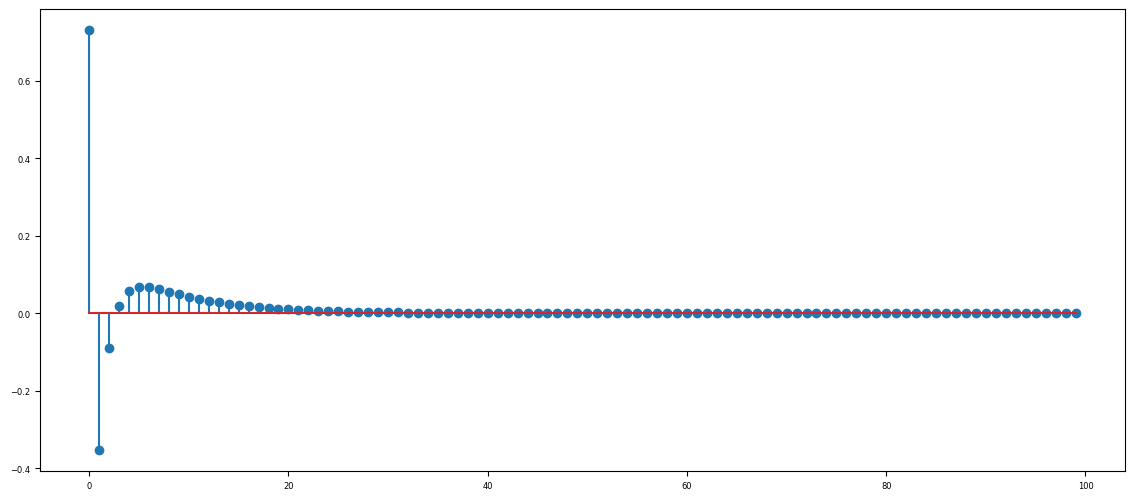

(PyObject <matplotlib.lines.Line2D object at 0x1473c9afe0d0>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x1473c9b170a0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b170d0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b17430>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b17790>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b17ac0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b1f160>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b1f490>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b1f7c0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b1faf0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9b1fe20>  …  PyObject <matplotlib.lines.Line2D object at 0x1473c9a67490>, PyObject <matplotlib.lines.Line2D object at 0x1473c9a677c0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9a67af0>, PyObject <matplotlib.lines.Line2D object at 0x1473c9a67e20>, PyObject <matplotlib.lines.Line2D object at 0x1473c99f5190>, PyOb

In [11]:
fig = figure("Title of Window",figsize=(14,6))
stem(h[1:100])

In [12]:
h[100]

1.6005060636266886e-7

In [13]:
h[200]

1.2523286955416236e-13

In [14]:
h[256]

4.764929688838567e-17

# this "INFINITE" IIR Biquad, for all practical purposes, decays to numerical ZERO after 250 samples... 

# BUT Wait-  if h is 250, its finite, and thus we have a FIR filter???  But I thought IIR and FIR filters were fundamentally Different???
## (they were, in the 20th century....)

## Lets see if this actually works. 

In [15]:
htrunc = h[1:256];

In [16]:
a = zeros(length(htrunc))
a[1] = 1.0

ytrunc = filt(vec(h),a,x);

In [17]:
length(y)

5000

In [18]:
length(ytrunc)

5000

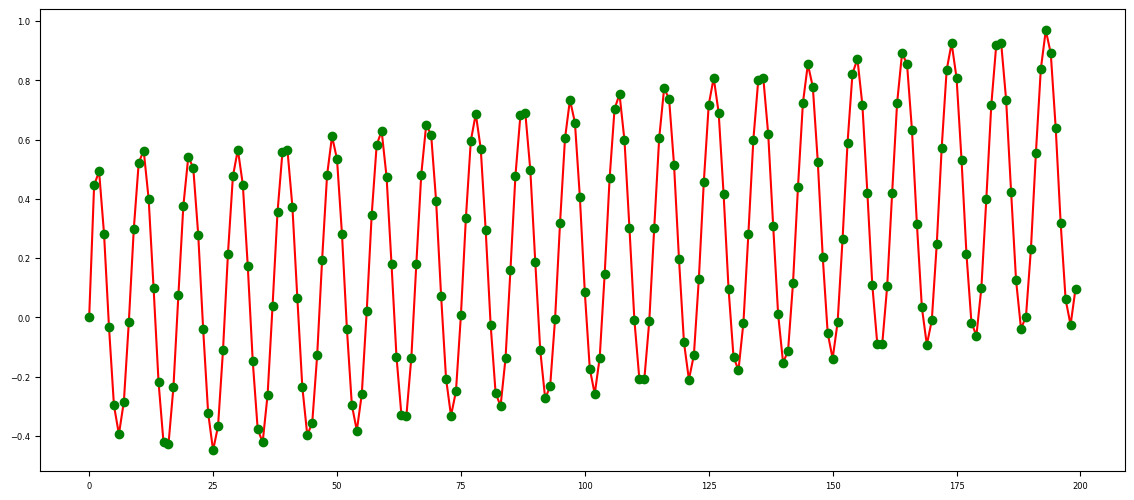

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473c99dfd90>

In [19]:
fig = figure("Title of Window",figsize=(14,6))
plot(y[1:200],"-r")
plot(ytrunc[1:200],"og")

# ALL useful IIR filters (i.e. stable...) have impulse response h that decays to zero
# so ALL IIR filters can be converted to FIR filters
# AND THIS MEANS we CAN USE FFT based convolution to implement ANY LTI filter we can dream up!!!!
## But we have Julia, so lets check out if this crazy talk is actually true!

<img src="FFTpseudo.png">

In [20]:
function naive_convolution(h,x)

    L = length(x)
    P = length(h)

    y = zeros(L+P-1)
    xp = zeros(L+P-1)
    hp = zeros(L+P-1)
    
    xp[1:L] = x
    xp[L+1:L+P-1] .= 0

    hp[1:P] = h
    hp[P+1:L+P-1] .= 0

    X = fft(xp)
    H = fft(hp)
    Y = X .* H
    y = ifft(Y)

    return(real(y))
    

end


naive_convolution (generic function with 1 method)

In [21]:
yfft = naive_convolution(vec(htrunc),x);

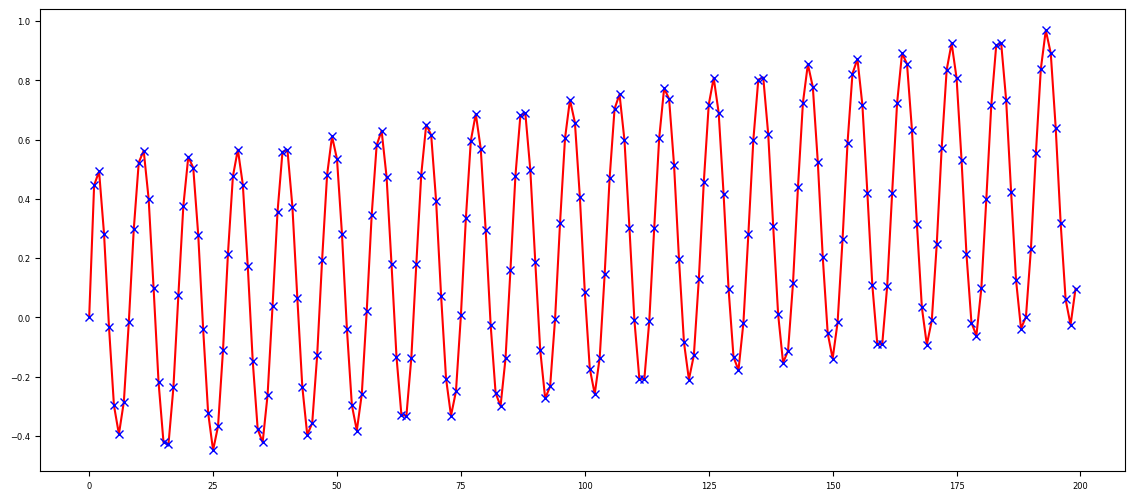

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1473c994eb50>

In [22]:
fig = figure("Title of Window",figsize=(14,6))
plot(y[1:200],"-r")
plot(yfft[1:200],"xb")

In [23]:
y[1:100] - yfft[1:100]

100-element Vector{Float64}:
 -8.653612766631096e-17
 -2.7755575615628914e-16
 -7.216449660063518e-16
 -8.881784197001252e-16
 -7.7021722333370235e-16
  5.551115123125783e-17
 -5.551115123125783e-17
  4.996003610813204e-16
  5.551115123125783e-16
  4.996003610813204e-16
  1.1102230246251565e-16
 -5.551115123125783e-16
 -9.992007221626409e-16
  ⋮
 -4.440892098500626e-16
 -9.43689570931383e-16
 -9.43689570931383e-16
 -5.273559366969494e-16
 -1.6653345369377348e-16
  5.273559366969494e-16
  6.730727086790012e-16
  7.216449660063518e-16
  1.1102230246251565e-16
 -6.661338147750939e-16
 -6.661338147750939e-16
 -1.27675647831893e-15

# IIR filters and FIR filters are the same, numerically. This is more important than you might realize.  

# I'm sure some of you have thought of a gotcha.  This only works "offline", not in "real time" like "real" "analog" IIR filters...

# OVERLAP-SAVE FFT Based Block Convolution!  

<img src="os1.png">

<img src="os2.png">

<img src="os3.png">

<img src="spectralconvolutionwhiteboard.jpg">

# Real-Time LTI Filtering (FIR and IIR) with FFT based Block Convolution.  Welcome to the 21st Century!!! 

# And there are no audio artifacts from a well done block convolution code. Just like Direct Form IIR is numerically equivalent to FFT Conolution...